# Day 2 — Evolving Fuzzy Systems for Data Streams & Concept Drift (UC3M Seminar)

**Instructor:** Prof. Dr. Paulo Vitor de Campos Souza  
**Venue:** Universidad Carlos III de Madrid (UC3M)  
**Duration:** 5 hours (Day 2)

---

## Learning goals

By the end of this notebook, students should be able to:

1. Explain why *data streams* require **online** learning (predict-then-update).
2. Recognize common **drift patterns** (abrupt, gradual, recurring).
3. Train an **evolving neuro-fuzzy system** online and interpret its *evolution*:
   - accuracy dynamics (including *rolling* accuracy),
   - rule base growth/merging,
   - feature relevance over time.
4. Connect **drift detection** with **model adaptation**.
5. Compare multiple **evolving fuzzy systems** from the `evolvingfuzzysystems` library under the same prequential protocol.

> Execute cells sequentially. Each cell is designed to produce immediate visual feedback.


---

## 0) Setup

This notebook assumes you have in the same folder:

- `evolving_nf_advanced.py` (your evolving neuro-fuzzy classifier used for didactic demonstrations)

Later, for the final benchmark section, you also need:

- `pip install evolvingfuzzysystems river scikit-learn pandas`

If you do not have the library installed yet, you can skip the benchmark section and still learn everything from Parts 1–3.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# Local model (didactic)
from models.evolving_nf_advanced import EvolvingNeuroFuzzyAdvanced

print("✓ Imports ok")

✓ Imports ok


---

## 1) Why online learning? (Predict-then-update)

In a **data stream**, observations arrive sequentially.  
We cannot assume we can store all past data or retrain from scratch.

A standard evaluation protocol is **prequential**:

1. **Predict** $\hat{y}_t$ using the current model
2. Observe the true label $y_t$
3. **Update** the model with $(x_t, y_t)$


---

## 2) Synthetic streams with controlled drift

We will create simple 2D classification streams where the decision boundary changes over time.

Scenarios:
- **No drift** (static)
- **Abrupt drift**
- **Gradual drift**
- **Recurring concepts**


In [2]:
from typing import Tuple, Dict

def generate_static_linear(n_samples: int, random_state: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(random_state)
    X = rng.normal(size=(n_samples, 2))
    y = (X[:, 0] + 0.5 * X[:, 1] > 0.0).astype(int)
    return X, y

def generate_abrupt_drift(n_samples: int, random_state: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(random_state)
    X = rng.normal(size=(n_samples, 2))
    y = np.zeros(n_samples, dtype=int)
    mid = n_samples // 2
    y[:mid] = (X[:mid, 0] + 0.5 * X[:mid, 1] > 0.0).astype(int)
    y[mid:] = (X[mid:, 0] - 0.8 * X[mid:, 1] > 0.3).astype(int)
    return X, y

def generate_gradual_drift(n_samples: int, random_state: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(random_state)
    X = rng.normal(size=(n_samples, 2))
    y = np.zeros(n_samples, dtype=int)

    a_start, b_start = 0.5, 0.0
    a_end, b_end = -0.8, 0.3

    for t in range(n_samples):
        alpha = t / max(n_samples - 1, 1)
        a_t = (1 - alpha) * a_start + alpha * a_end
        b_t = (1 - alpha) * b_start + alpha * b_end
        y[t] = (X[t, 0] + a_t * X[t, 1] > b_t).astype(int)

    return X, y

def generate_recurring_concepts(n_samples: int, random_state: int = 0) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(random_state)
    X = rng.normal(size=(n_samples, 2))
    y = np.zeros(n_samples, dtype=int)
    third = n_samples // 3
    y[:third] = (X[:third, 0] + 0.5 * X[:third, 1] > 0.0).astype(int)
    y[third:2*third] = (X[third:2*third, 0] - 0.8 * X[third:2*third, 1] > 0.3).astype(int)
    y[2*third:] = (X[2*third:, 0] + 0.5 * X[2*third:, 1] > 0.0).astype(int)
    return X, y

SCENARIOS = {
    "static_linear": generate_static_linear,
    "abrupt_drift": generate_abrupt_drift,
    "gradual_drift": generate_gradual_drift,
    "recurring_concepts": generate_recurring_concepts,
}

def drift_metadata(scenario_name: str, n: int):
    meta = []
    if scenario_name == "abrupt_drift":
        meta.append({"label": "drift", "start": n//2, "end": n//2})
    elif scenario_name == "gradual_drift":
        meta.append({"label": "start", "start": n//4, "end": n//4})
        meta.append({"label": "end", "start": 3*n//4, "end": 3*n//4})
        meta.append({"label": "drift-window", "start": n//4, "end": 3*n//4})
    elif scenario_name == "recurring_concepts":
        meta.append({"label": "A→B", "start": n//3, "end": n//3})
        meta.append({"label": "B→A", "start": 2*n//3, "end": 2*n//3})
    return meta

print("✓ Stream generators ready")

✓ Stream generators ready


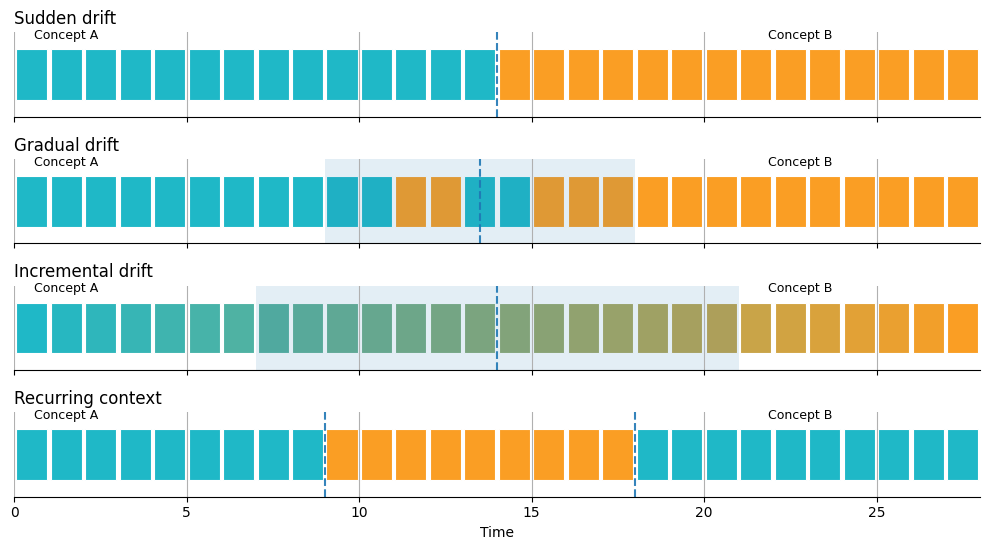

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def _blend(c1, c2, a):
    c1 = np.array(c1, float)
    c2 = np.array(c2, float)
    return tuple((1 - a) * c1 + a * c2)

def plot_drift_schematics_scientific(
    n_blocks=28,
    cA=(0.12, 0.72, 0.78),   # A
    cB=(0.98, 0.62, 0.14),   # B
    show_labels=True,
    line_alpha=0.9,
    shade_alpha=0.12,
):
    """
    Draw schematic drift patterns with scientific markers:
      - Sudden (abrupt): vertical line at drift point
      - Gradual: shaded transition window + dashed center line
      - Incremental: shaded transition window + dashed center line
      - Recurring context: vertical lines at switches
    """

    # ---------- define patterns + markers ----------
    patterns = {}

    # 1) Sudden: A then B
    p = n_blocks // 2
    sudden = [cA] * p + [cB] * (n_blocks - p)
    patterns["Sudden drift"] = dict(
        cols=sudden,
        vlines=[p],            # drift point
        window=None
    )

    # 2) Gradual: probabilistic mixing in [start, end]
    rng = np.random.default_rng(0)
    start = n_blocks // 3
    end = 2 * n_blocks // 3
    gradual = []
    for i in range(n_blocks):
        if i < start:
            gradual.append(cA)
        elif i > end:
            gradual.append(cB)
        else:
            a = (i - start) / max(1, (end - start))
            gradual.append(cB if rng.random() < a else cA)

    patterns["Gradual drift"] = dict(
        cols=gradual,
        vlines=[(start + end) / 2],   # center marker
        window=(start, end)           # transition window
    )

    # 3) Incremental: smooth color blend A -> B across entire horizon (or a window)
    incremental = []
    for i in range(n_blocks):
        a = i / max(1, (n_blocks - 1))
        incremental.append(_blend(cA, cB, a))

    # you can set a window; here we mark the middle half as “transition”
    inc_start = n_blocks * 0.25
    inc_end = n_blocks * 0.75

    patterns["Incremental drift"] = dict(
        cols=incremental,
        vlines=[(inc_start + inc_end) / 2],
        window=(inc_start, inc_end)
    )

    # 4) Recurring context: A -> B -> A
    third = n_blocks // 3
    recurring = [cA] * third + [cB] * third + [cA] * (n_blocks - 2 * third)
    patterns["Recurring context"] = dict(
        cols=recurring,
        vlines=[third, 2 * third],   # switches
        window=None
    )

    # ---------- plot ----------
    fig, axes = plt.subplots(4, 1, figsize=(10, 5.6), sharex=True)
    plt.subplots_adjust(hspace=0.85)

    for ax, (title, spec) in zip(axes, patterns.items()):
        cols = spec["cols"]
        vlines = spec["vlines"]
        window = spec["window"]

        ax.set_title(title, loc="left", fontsize=12)
        ax.set_yticks([])
        ax.set_xlim(0, n_blocks)
        ax.set_ylim(0, 1)

        # draw blocks
        for i, col in enumerate(cols):
            ax.add_patch(
                Rectangle((i + 0.05, 0.2), 0.9, 0.6,
                          facecolor=col, edgecolor="white", linewidth=0.8)
            )

        # shaded drift window (if any)
        if window is not None:
            a, b = window
            ax.axvspan(a, b, alpha=shade_alpha)

        # drift/switch lines
        for x in vlines:
            ax.axvline(x, linestyle="--", linewidth=1.5, alpha=line_alpha)

        # optional A/B labels
        if show_labels:
            ax.text(0.02, 0.92, "Concept A", transform=ax.transAxes, fontsize=9)
            ax.text(0.78, 0.92, "Concept B", transform=ax.transAxes, fontsize=9)

        # clean spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

# Demo
plot_drift_schematics_scientific()


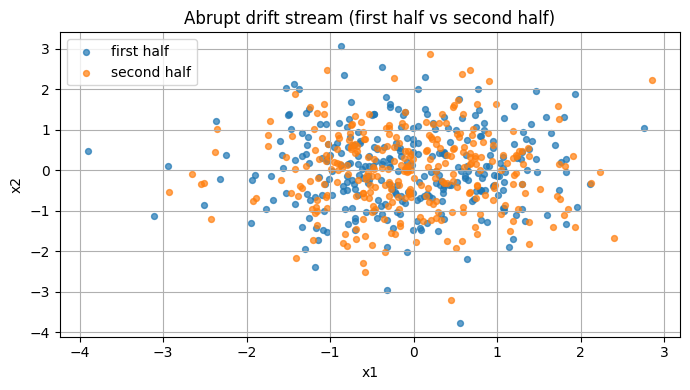

In [22]:
def plot_stream_2d(X, y, title="Stream (2D)"):
    n = len(y)
    mid = n//2
    plt.figure(figsize=(7, 4))
    plt.scatter(X[:mid, 0], X[:mid, 1], s=18, alpha=0.7, label="first half")
    plt.scatter(X[mid:, 0], X[mid:, 1], s=18, alpha=0.7, label="second half")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.tight_layout()
    plt.show()

X_demo, y_demo = SCENARIOS["abrupt_drift"](n_samples=600, random_state=0)
plot_stream_2d(X_demo, y_demo, title="Abrupt drift stream (first half vs second half)")

---

## 3) Prequential evaluation for the local evolving neuro-fuzzy model

We track:
- cumulative accuracy
- rolling accuracy (best for drift visualization)
- number of rules
- feature relevance weights (if exposed by the model)


In [4]:
def rolling_mean(x: np.ndarray, window: int = 200) -> np.ndarray:
    x = np.asarray(x, float)
    if window <= 1:
        return x.copy()
    out = np.full_like(x, np.nan, dtype=float)
    c = np.cumsum(np.insert(x, 0, 0.0))
    for i in range(window, len(x) + 1):
        out[i-1] = (c[i] - c[i-window]) / window
    for i in range(min(window-1, len(x))):
        out[i] = np.mean(x[:i+1])
    return out

def prequential_nf(X: np.ndarray, y: np.ndarray, model_params=None, rolling_window: int = 200):
    if model_params is None:
        model_params = {}

    n, d = X.shape
    n_classes = len(np.unique(y))

    model = EvolvingNeuroFuzzyAdvanced(n_features=d, n_classes=n_classes, **model_params)

    correct = np.zeros(n, dtype=float)
    acc = np.zeros(n, dtype=float)
    rules_t = np.zeros(n, dtype=int)
    featw_t = np.zeros((n, d), dtype=float)

    for t in range(n):
        x_t = X[t:t+1]
        y_t = int(y[t])

        if t == 0 or len(model.rules) == 0:
            y_hat = 0
        else:
            y_hat = int(model.predict(x_t)[0])

        correct[t] = 1.0 if y_hat == y_t else 0.0
        acc[t] = correct[:t+1].mean()

        model.partial_fit(x_t, np.array([y_t]))

        rules_t[t] = len(model.rules)
        try:
            featw_t[t] = model.sep_buffer.compute_feature_weights()
        except Exception:
            featw_t[t] = np.nan

    acc_roll = rolling_mean(correct, window=rolling_window)
    return {"model": model, "acc": acc, "acc_roll": acc_roll, "rules": rules_t, "featw": featw_t, "correct": correct}

def add_drift_markers(ax, meta):
    for m in meta:
        if m.get("label") == "drift-window":
            ax.axvspan(m["start"], m["end"], alpha=0.12, color="red", label="drift window")
        else:
            ax.axvline(m["start"], linestyle="--", color="red", linewidth=1.2, alpha=0.9)

def plot_nf_results(scenario_name: str, res: Dict, rolling_window: int):
    n = len(res["acc"])
    meta = drift_metadata(scenario_name, n)
    t = np.arange(n)

    plt.figure(figsize=(10, 4))
    plt.plot(t, res["acc"], label="Cumulative prequential accuracy")
    plt.plot(t, res["acc_roll"], label=f"Rolling accuracy (window={rolling_window})")
    ax = plt.gca()
    add_drift_markers(ax, meta)
    plt.title(f"Accuracy over time — {scenario_name}")
    plt.xlabel("time step")
    plt.ylabel("accuracy")
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 3.6))
    plt.plot(t, res["rules"], label="#rules")
    ax = plt.gca()
    add_drift_markers(ax, meta)
    plt.title(f"Rule base size over time — {scenario_name}")
    plt.xlabel("time step")
    plt.ylabel("#rules")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 3.6))
    for j in range(res["featw"].shape[1]):
        plt.plot(t, res["featw"][:, j], label=f"feature {j+1}")
    ax = plt.gca()
    add_drift_markers(ax, meta)
    plt.title(f"Feature relevance over time — {scenario_name}")
    plt.xlabel("time step")
    plt.ylabel("weight (normalized)")
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

print("✓ Prequential + plotting ready")

✓ Prequential + plotting ready


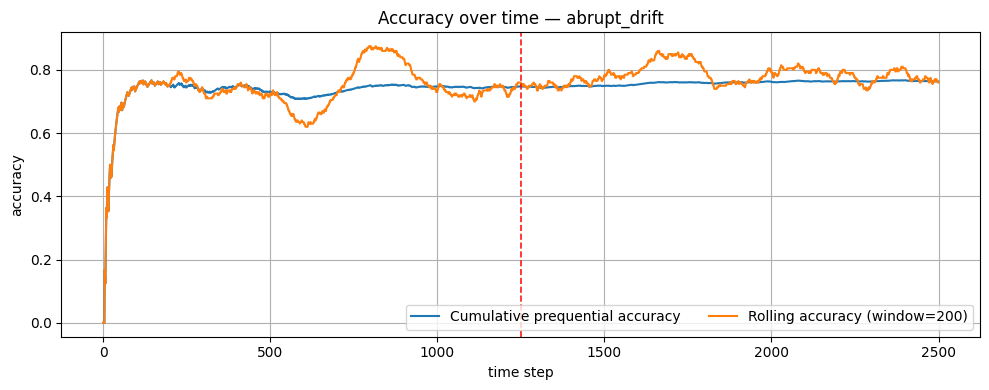

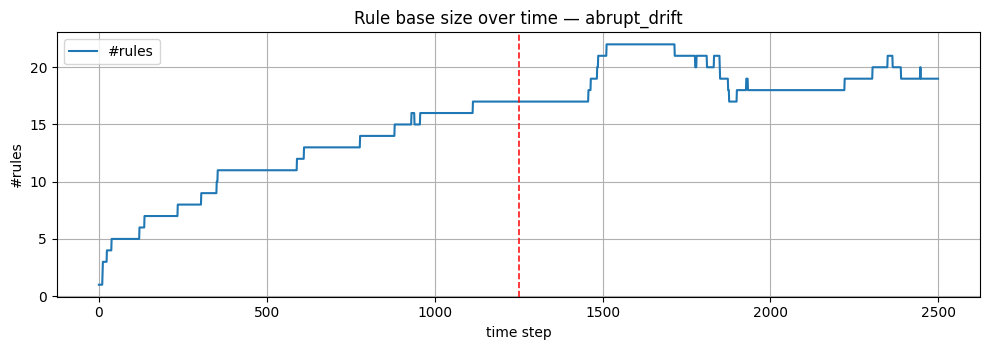

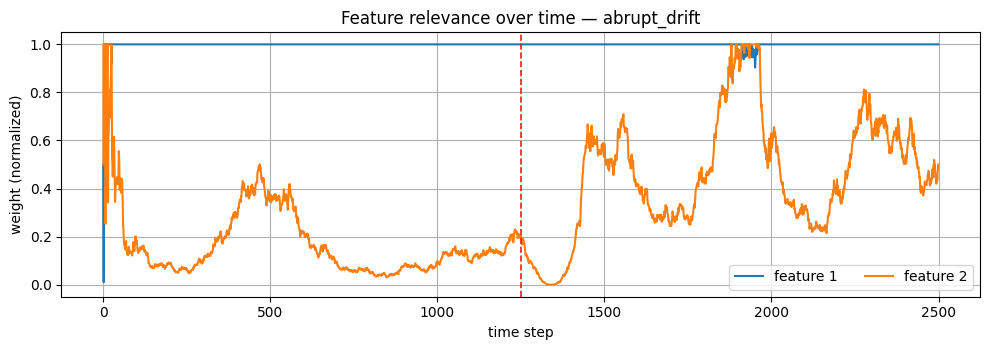

Final cumulative accuracy: 0.7632
Final number of rules: 19
Max number of rules: 22


In [5]:
# --- seminar-friendly defaults (fast + illustrative) ---
n_samples = 2500
rolling_window = 200

model_params = dict(
    alpha_add=0.25,
    tau_merge=0.85,
    lambda_sim=0.6,
    buffer_size_similarity=150,
    buffer_size_separability=200,
    max_rules=40,
)

scenario_name = "abrupt_drift"  # try: static_linear, abrupt_drift, gradual_drift, recurring_concepts
X, y = SCENARIOS[scenario_name](n_samples=n_samples, random_state=1)

res = prequential_nf(X, y, model_params=model_params, rolling_window=rolling_window)
plot_nf_results(scenario_name, res, rolling_window=rolling_window)

print("Final cumulative accuracy:", float(res["acc"][-1]))
print("Final number of rules:", int(res["rules"][-1]))
print("Max number of rules:", int(res["rules"].max()))

---

## 4) Drift detection (simple demonstration on the error stream)

We feed the error stream (1 if wrong, 0 if correct) into a drift detector (ADWIN).


In [6]:
try:
    from river.drift import ADWIN
    river_ok = True
    print("✓ river is available (ADWIN)")
except Exception as e:
    river_ok = False
    print("river not available:", repr(e))
    print("Install with: pip install river")

✓ river is available (ADWIN)


Detected drift points (ADWIN): [735, 1663] 


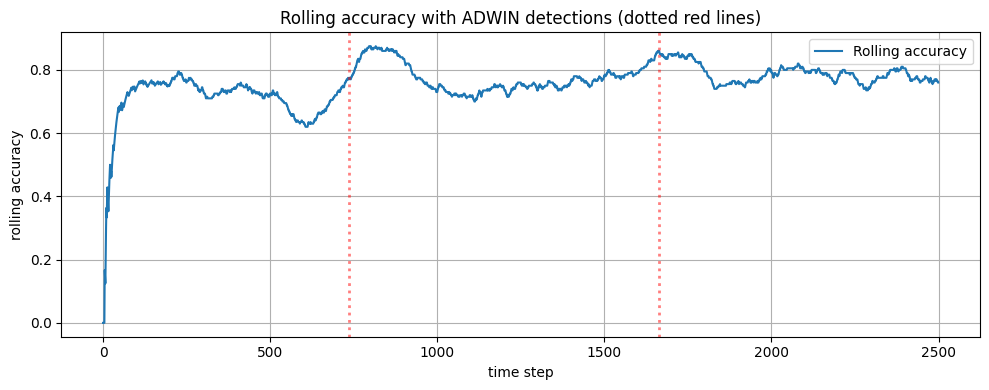

In [14]:
from river.drift import ADWIN

def detect_drifts_adwin(error_stream: np.ndarray, delta: float = 0.002):
    if not river_ok:
        return []
    adwin = ADWIN(delta=delta)
    detected = []

    for t, err in enumerate(error_stream):
        adwin.update(float(err))

        # river versions differ: try the common flags
        if getattr(adwin, "drift_detected", False) or getattr(adwin, "change_detected", False):
            detected.append(t)

    return detected

if river_ok:
    error_stream = 1.0 - res["correct"]
    detected = detect_drifts_adwin(error_stream, delta=0.2)
    print("Detected drift points (ADWIN):", detected[:10], "..." if len(detected) > 10 else "")

    t = np.arange(len(res["acc_roll"]))
    plt.figure(figsize=(10, 4))
    plt.plot(t, res["acc_roll"], label="Rolling accuracy")
    for idx in detected[:20]:
        plt.axvline(idx, color="red", linewidth=2.0, alpha=0.5, linestyle=":")
    plt.title("Rolling accuracy with ADWIN detections (dotted red lines)")
    plt.xlabel("time step")
    plt.ylabel("rolling accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()


---

# Part II — Benchmark with the `evolvingfuzzysystems` library (SOTA comparison)

We compare multiple evolving fuzzy models under the same prequential protocol:

- Warmup: `fit()` on the first samples
- Then: predict on the next block, update via `evolve()` every `batch_evolve` samples
- Normalize features to **[0,1]** (recommended by the library)


In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [16]:
# --- Optional imports: evolvingfuzzysystems + river datasets ---
try:
    from river import datasets
    from river.datasets import synth
    from evolvingfuzzysystems.eFS import ePL, ePL_plus, exTS, Simpl_eTS, eMG, ePL_KRLS_DISCO
    from evolvingfuzzysystems.classification import ENFS_Uni0
    efs_ok = True
    print("✓ evolvingfuzzysystems + river imported")
except Exception as e:
    efs_ok = False
    print("Optional libs not available:", repr(e))
    print("Install with: pip install evolvingfuzzysystems river")

✓ evolvingfuzzysystems + river imported


In [17]:
def load_stream_to_numpy(ds, n_max: int = 5000):
    X_list = []
    y_raw = []

    it = ds.__iter__() if hasattr(ds, "__iter__") else iter(ds)
    x0, y0 = next(it)
    feat_names = list(x0.keys())

    X_list.append(np.array([x0[f] for f in feat_names], float))
    y_raw.append(y0)

    for i, (x, y) in enumerate(it, start=1):
        if i >= n_max:
            break
        X_list.append(np.array([x[f] for f in feat_names], float))
        y_raw.append(y)

    X = np.vstack(X_list).astype(float)
    uniq = list(dict.fromkeys(y_raw))
    enc = {lab: i for i, lab in enumerate(uniq)}
    y_int = np.array([enc[v] for v in y_raw], int)
    return X, y_int, uniq

def coerce_pred_to_labels(y_hat, y_true):
    y_true = np.asarray(y_true).reshape(-1)
    labels = np.unique(y_true)
    y_hat = np.asarray(y_hat).reshape(-1)

    if np.issubdtype(y_hat.dtype, np.integer) or np.all(np.isclose(y_hat, np.rint(y_hat))):
        y_hat_i = np.rint(y_hat).astype(int)
        lo, hi = int(labels.min()), int(labels.max())
        return np.clip(y_hat_i, lo, hi)

    if len(labels) == 2:
        return (y_hat >= 0.5).astype(int)

    y_hat_i = np.rint(y_hat).astype(int)
    lo, hi = int(labels.min()), int(labels.max())
    return np.clip(y_hat_i, lo, hi)

def update_model_batch(model, Xb, yb):
    if hasattr(model, "evolve"):
        try:
            model.evolve(Xb, yb)
        except Exception:
            model.evolve(Xb, np.asarray(yb).reshape(-1, 1))
    else:
        try:
            model.fit(Xb, yb)
        except Exception:
            model.fit(Xb, np.asarray(yb).reshape(-1, 1))

def try_get_n_rules(model):
    if hasattr(model, "n_rules") and callable(getattr(model, "n_rules")):
        try:
            return int(model.n_rules())
        except Exception:
            return np.nan
    if hasattr(model, "rules"):
        try:
            return int(len(model.rules))
        except Exception:
            return np.nan
    return np.nan

def prequential_efs_warmup_evolve(model, X, y, warmup=200, batch_evolve=50, rolling_window=200):
    X = np.asarray(X, float)
    y = np.asarray(y, int)

    scaler = MinMaxScaler()
    Xs = scaler.fit_transform(X)

    warmup = min(warmup, len(y))
    model.fit(Xs[:warmup], y[:warmup])

    y_true_seen = []
    y_pred_seen = []
    acc_batch = []
    correct = []
    rules = []

    t = warmup
    while t < len(y):
        Xb = Xs[t:t+batch_evolve]
        yb = y[t:t+batch_evolve]

        y_hat = model.predict(Xb)
        y_hat_lbl = coerce_pred_to_labels(y_hat, yb)

        y_true_seen.extend(yb.tolist())
        y_pred_seen.extend(y_hat_lbl.tolist())

        corr = (y_hat_lbl.reshape(-1) == yb.reshape(-1)).astype(float)
        correct.extend(corr.tolist())

        acc_batch.append(accuracy_score(np.asarray(y_true_seen), np.asarray(y_pred_seen)))

        update_model_batch(model, Xb, yb)
        rules.append(try_get_n_rules(model))
        t += batch_evolve

    acc_batch = np.asarray(acc_batch, float)
    correct = np.asarray(correct, float)
    acc_roll = rolling_mean(correct, window=rolling_window)
    return {"acc_batch": acc_batch, "acc_roll": acc_roll, "rules": np.asarray(rules, float)}

## 5) Synthetic benchmark stream (with known drift markers)

We use a classic setup: **Agrawal → Agrawal** with a drift window.

This is ideal for teaching because:
- we know the drift location (`position`, `width`)
- we can compare models consistently


In [18]:
if efs_ok:
    drift_position = 2500
    drift_width = 1000

    ds = synth.ConceptDriftStream(
        stream=synth.Agrawal(seed=1),
        drift_stream=synth.Agrawal(seed=2),
        seed=42,
        position=drift_position,
        width=drift_width,
    )

    X_raw, y_int, labels = load_stream_to_numpy(ds, n_max=5000)
    print("X:", X_raw.shape, "labels:", labels, "encoded:", np.unique(y_int))

X: (5000, 9) labels: [1, 0] encoded: [0 1]


In [34]:
# ============================================================
# Robust benchmark runner (ENFS_Uni0 + evolvingfuzzysystems eFS)
# ============================================================
import warnings
import numpy as np
import pandas as pd
from time import perf_counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# -----------------------------
# 0) Clean console for seminar
# -----------------------------
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
np.seterr(over="ignore", invalid="ignore", divide="ignore")


# -----------------------------
# 1) Helper utilities
# -----------------------------
def _ensure_1d_float(y):
    """Force y to be 1D float array (n,) to avoid 'sequence' issues inside some eFS implementations."""
    return np.asarray(y).ravel().astype(np.float64)

def _ensure_1d_int(y):
    """Force y to be 1D int array (n,)."""
    return np.asarray(y).ravel().astype(int)

def _predict_score_scalar(model, x_row):
    """
    Robust score extraction:
    accepts scalar, 1d, 2d, list/tuple of arrays.
    Always returns one float.
    """
    yhat = model.predict(x_row)

    if isinstance(yhat, (list, tuple)):
        if len(yhat) == 0:
            return 0.0
        yhat = yhat[0]

    arr = np.asarray(yhat)
    if arr.size == 0:
        return 0.0

    return float(arr.ravel()[0])

def _n_rules(model):
    """Best-effort rule count across different model APIs."""
    if hasattr(model, "n_rules") and callable(getattr(model, "n_rules")):
        try:
            return int(model.n_rules())
        except Exception:
            return np.nan
    if hasattr(model, "rules"):
        try:
            return int(len(model.rules))
        except Exception:
            return np.nan
    if hasattr(model, "parameters"):
        # some models store rule params in a dataframe-like structure
        try:
            return int(len(model.parameters))
        except Exception:
            return np.nan
    return np.nan

def _rolling_mean(x, window):
    x = np.asarray(x, float)
    out = np.full_like(x, np.nan, dtype=float)
    c = np.cumsum(np.insert(x, 0, 0.0))
    for i in range(1, len(x) + 1):
        j0 = max(0, i - window)
        out[i - 1] = (c[i] - c[j0]) / (i - j0)
    return out


# -----------------------------
# 2) Hybrid prequential protocol
# -----------------------------
def prequential_hybrid(
    model,
    X_raw,
    y_int,
    warmup=200,
    batch_evolve=50,
    rolling_window=250,
    threshold=0.5,
):
    """
    Hybrid prequential evaluator:

    - If model has evolve(): warmup fit + batch evolve (most eFS models)
    - Else if model has partial_fit(): sample-by-sample updates (ENFS_Uni0-like)
    - Else: fallback incremental batch fit

    Returns:
      acc_batch: accuracy measured every batch_evolve steps
      acc_roll: rolling accuracy per sample (after warmup)
      rules: rule count tracked every batch_evolve steps
      correct_stream: 0/1 per sample correctness (after warmup)
      mode: 'evolve' | 'partial_fit' | 'fit_batch'
    """

    X_raw = np.asarray(X_raw, dtype=np.float64)
    y_int = _ensure_1d_int(y_int)

    # safety for NaN/Inf inputs
    X_raw = np.nan_to_num(X_raw, nan=0.0, posinf=1.0, neginf=0.0)

    # library recommends scaling to [0,1]
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X_raw)

    n = len(y_int)
    warmup = min(warmup, n)

    has_evolve = hasattr(model, "evolve") and callable(getattr(model, "evolve", None))
    has_partial = hasattr(model, "partial_fit") and callable(getattr(model, "partial_fit", None))

    # --- warmup ---
    X_init = X[:warmup]
    classes = np.unique(y_int)

    if has_evolve:
        mode = "evolve"
        y_init = _ensure_1d_float(y_int[:warmup])
        # try fit with (n,) then fallback (n,1)
        try:
            model.fit(X_init, y_init)
        except Exception:
            model.fit(X_init, y_init.reshape(-1, 1))

    elif has_partial:
        mode = "partial_fit"
        # warmup sample-by-sample
        for i in range(warmup):
            xi = X_init[i:i+1]
            yi = y_int[i:i+1]
            if i == 0:
                # some sklearn-like APIs require classes on first call
                try:
                    model.partial_fit(xi, yi, classes=classes)
                except TypeError:
                    model.partial_fit(xi, yi)
            else:
                model.partial_fit(xi, yi)

    else:
        mode = "fit_batch"
        y_init = _ensure_1d_float(y_int[:warmup])
        try:
            model.fit(X_init, y_init)
        except Exception:
            model.fit(X_init, y_init.reshape(-1, 1))

    # --- prequential loop ---
    y_true_seen, y_pred_seen = [], []
    correct_stream = []
    acc_batch, rules_hist = [], []

    bufX, bufy = [], []

    for t in range(warmup, n):
        x_t = X[t:t+1]
        y_t = int(y_int[t])

        # predict score -> binary label
        score = _predict_score_scalar(model, x_t)
        y_hat = int(score >= threshold)

        y_true_seen.append(y_t)
        y_pred_seen.append(y_hat)
        correct_stream.append(1.0 if y_hat == y_t else 0.0)

        # update model
        if mode == "evolve":
            bufX.append(x_t.ravel())
            bufy.append(float(y_int[t]))
            if len(bufy) >= batch_evolve:
                X_block = np.vstack(bufX)
                y_block = _ensure_1d_float(np.array(bufy))
                try:
                    model.evolve(X_block, y_block)
                except Exception:
                    model.evolve(X_block, y_block.reshape(-1, 1))
                bufX, bufy = [], []

        elif mode == "partial_fit":
            model.partial_fit(x_t, np.array([y_t], dtype=int))

        else:
            bufX.append(x_t.ravel())
            bufy.append(float(y_int[t]))
            if len(bufy) >= batch_evolve:
                X_block = np.vstack(bufX)
                y_block = _ensure_1d_float(np.array(bufy))
                try:
                    model.fit(X_block, y_block)
                except Exception:
                    model.fit(X_block, y_block.reshape(-1, 1))
                bufX, bufy = [], []

        # log every batch
        if (t - warmup + 1) % batch_evolve == 0:
            acc_batch.append(accuracy_score(np.asarray(y_true_seen), np.asarray(y_pred_seen)))
            rules_hist.append(_n_rules(model))

    correct_stream = np.asarray(correct_stream, float)
    acc_roll = _rolling_mean(correct_stream, rolling_window)

    return {
        "acc_batch": np.asarray(acc_batch, float),
        "acc_roll": acc_roll,
        "rules": np.asarray(rules_hist, float),
        "correct_stream": correct_stream,
        "mode": mode,
    }


# -----------------------------
# 3) Run benchmark safely (skip failing models)
# -----------------------------
# Expect MODELS defined like:
# MODELS = [("ENFS_Uni0", lambda: ENFS_Uni0(...)), ("ePL", lambda: ePL()), ...]
#
# Also expect X_raw and y_int already prepared in your notebook.

warmup = 200
batch_evolve = 50
rolling_window = 250
threshold = 0.5

rows = []
all_results = {}
failed = []

for name, ctor in MODELS:
    print("Running:", name)
    model = ctor()

    t0 = perf_counter()
    try:
        res = prequential_hybrid(
            model,
            X_raw=X_raw,
            y_int=y_int,
            warmup=warmup,
            batch_evolve=batch_evolve,
            rolling_window=rolling_window,
            threshold=threshold,
        )
        dt = perf_counter() - t0

        all_results[name] = res
        rows.append({
            "model": name,
            "mode": res.get("mode", "?"),
            "final_acc_batch": float(res["acc_batch"][-1]) if len(res["acc_batch"]) else np.nan,
            "mean_acc_batch": float(np.mean(res["acc_batch"])) if len(res["acc_batch"]) else np.nan,
            "final_rules": float(res["rules"][-1]) if len(res["rules"]) else np.nan,
            "runtime_s": float(dt),
        })

    except Exception as e:
        dt = perf_counter() - t0
        print(f"  ✗ Failed: {name} -> {repr(e)}  (skipping)")
        failed.append(name)

df_summary = pd.DataFrame(rows).sort_values("final_acc_batch", ascending=False)
print("\nFailed models:", failed)
df_summary


Running: ENFS_Uni0
Running: ePL
Running: ePL_plus
Running: exTS
Running: Simpl_eTS
Running: eMG
Running: ePL_KRLS_DISCO
  ✗ Failed: ePL_KRLS_DISCO -> TypeError('only 0-dimensional arrays can be converted to Python scalars')  (skipping)

Failed models: ['ePL_KRLS_DISCO']


,model,mode,final_acc_batch,mean_acc_batch,final_rules,runtime_s
0,ENFS_Uni0,fit_batch,0.682500,0.681107,10.0,10.691314
1,ePL,evolve,0.680417,0.670920,1.0,2.652115
2,ePL_plus,evolve,0.680000,0.668756,1.0,2.858374
3,exTS,evolve,0.676875,0.664612,3.0,7.569246
5,eMG,evolve,0.668333,0.633847,58.0,148.570099
4,Simpl_eTS,evolve,0.665625,0.650719,8.0,11.079988


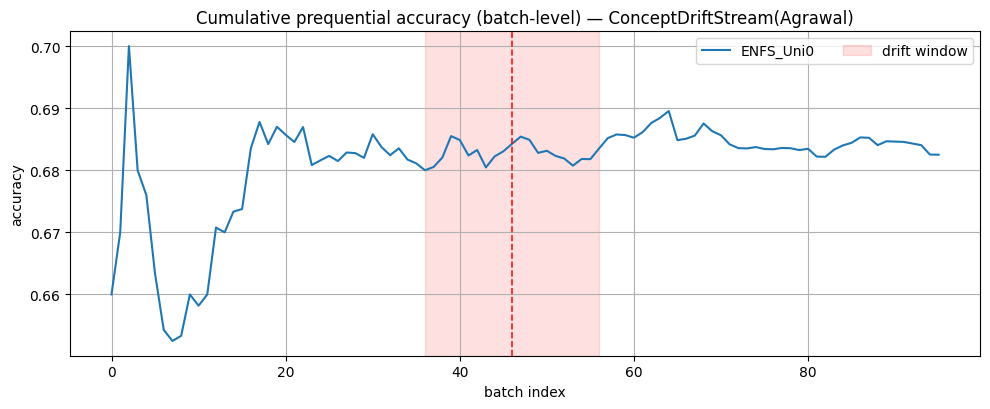

In [35]:
if efs_ok:
    # drift markers in batch-time coordinates (acc_batch is per batch after warmup)
    t_batches = np.arange(len(next(iter(results_lib.values()))["acc_batch"]))

    drift_center_batch = max(0, (drift_position - warmup) // batch_evolve)
    drift_start_batch  = max(0, ((drift_position - drift_width//2) - warmup) // batch_evolve)
    drift_end_batch    = max(0, ((drift_position + drift_width//2) - warmup) // batch_evolve)

    plt.figure(figsize=(10, 4.2))
    for name, resm in results_lib.items():
        plt.plot(t_batches, resm["acc_batch"], label=name)

    ax = plt.gca()
    ax.axvspan(drift_start_batch, drift_end_batch, alpha=0.12, color="red", label="drift window")
    ax.axvline(drift_center_batch, linestyle="--", color="red", linewidth=1.2, alpha=0.9)

    plt.title("Cumulative prequential accuracy (batch-level) — ConceptDriftStream(Agrawal)")
    plt.xlabel("batch index")
    plt.ylabel("accuracy")
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

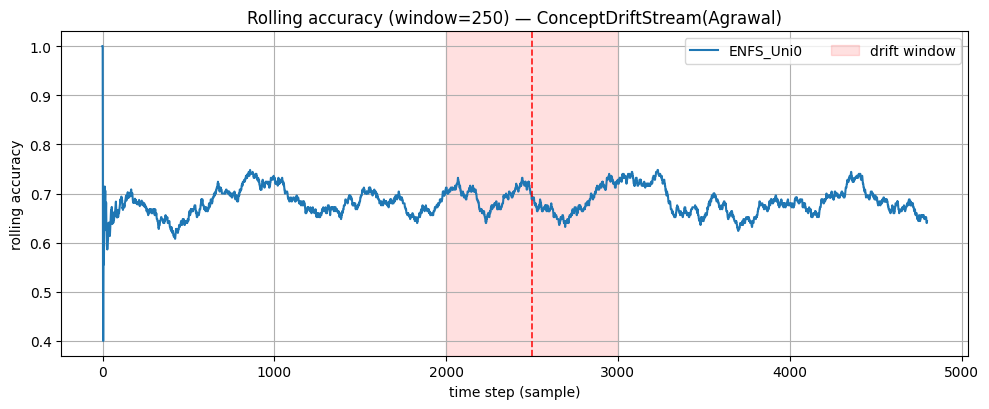

In [36]:
if efs_ok:
    plt.figure(figsize=(10, 4.2))
    for name, resm in results_lib.items():
        plt.plot(resm["acc_roll"], label=name)

    ax = plt.gca()
    ax.axvspan(drift_position - drift_width//2, drift_position + drift_width//2, alpha=0.12, color="red", label="drift window")
    ax.axvline(drift_position, linestyle="--", color="red", linewidth=1.2, alpha=0.9)

    plt.title(f"Rolling accuracy (window={rolling_window}) — ConceptDriftStream(Agrawal)")
    plt.xlabel("time step (sample)")
    plt.ylabel("rolling accuracy")
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

In [38]:
if efs_ok:
    rows = []
    for name, resm in results_lib.items():
        rows.append({
            "model": name,
            "final_acc_batch": float(resm["acc_batch"][-1]) if len(resm["acc_batch"]) else np.nan,
            "mean_acc_batch": float(np.mean(resm["acc_batch"])) if len(resm["acc_batch"]) else np.nan,
            "final_rules": float(resm["rules"][-1]) if len(resm["rules"]) else np.nan,
        })
    df = pd.DataFrame(rows).sort_values("final_acc_batch", ascending=False)
    df

---

## 6) Optional real stream: Elec2

Real streams do not provide explicit drift points, but rolling accuracy and drift detectors can still be used.


In [39]:
if efs_ok:
    ds_real = datasets.Elec2()
    Xr, yr, labels_r = load_stream_to_numpy(ds_real, n_max=8000)
    print("Elec2:", Xr.shape, "classes:", labels_r)

Elec2: (8000, 8) classes: [True, False]


Running: ENFS_Uni0
  ✓ done in 15.97s | mode: fit_batch
Running: ePL
  ✓ done in 3.91s | mode: evolve
Running: exTS
  ✓ done in 13.53s | mode: evolve
Running: eMG
  ✓ done in 8.38s | mode: evolve


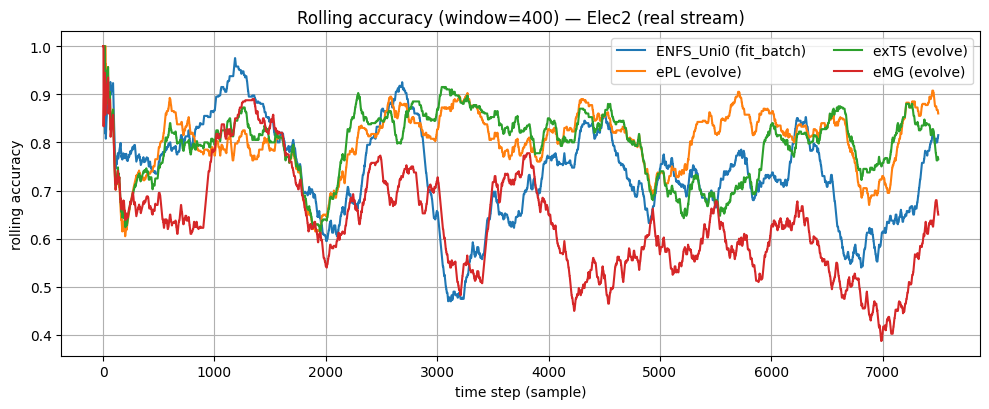

Failed models (real stream): []


In [41]:
if efs_ok:
    import numpy as np
    import matplotlib.pyplot as plt
    from time import perf_counter

    d = Xr.shape[1]
    n_classes = len(np.unique(yr))

    MODELS_REAL = [
        ("ENFS_Uni0", lambda: ENFS_Uni0(
            n_features=d, n_classes=n_classes,
            lambda_ff=0.99, sim_threshold=0.95, max_rules=10,
            random_state=42
        )),
        ("ePL", lambda: ePL()),
        ("exTS", lambda: exTS()),
        ("eMG", lambda: eMG()),
    ]

    warmup = 500
    batch_evolve = 100
    rolling_window = 400
    threshold = 0.5  # if you see weird results, try 0.0 too

    results_real = {}
    failed_real = []

    for name, ctor in MODELS_REAL:
        print("Running:", name)
        model = ctor()

        t0 = perf_counter()
        try:
            results_real[name] = prequential_hybrid(
                model,
                X_raw=Xr,
                y_int=yr,
                warmup=warmup,
                batch_evolve=batch_evolve,
                rolling_window=rolling_window,
                threshold=threshold
            )
            dt = perf_counter() - t0
            print(f"  ✓ done in {dt:.2f}s | mode: {results_real[name].get('mode','?')}")

        except Exception as e:
            dt = perf_counter() - t0
            print(f"  ✗ Failed: {name} -> {repr(e)}  (skipping)")
            failed_real.append(name)

    # ---- Plot rolling accuracy ----
    plt.figure(figsize=(10, 4.2))
    for name, resm in results_real.items():
        plt.plot(resm["acc_roll"], label=f"{name} ({resm.get('mode','?')})")

    plt.title(f"Rolling accuracy (window={rolling_window}) — Elec2 (real stream)")
    plt.xlabel("time step (sample)")
    plt.ylabel("rolling accuracy")
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

    print("Failed models (real stream):", failed_real)


---

## Wrap-up discussion prompts

1. **When does drift matter the most?**
2. **Accuracy vs interpretability trade-off** (rule base size).
3. **Why evolving fuzzy systems?**  
   online adaptation + inspectable rules.
4. **How would you deploy this?**  
   monitor accuracy, drift alarms, and rule evolution.
